In [ ]:
!pip install beautifulsoup4

In [ ]:
!pip install emoji
!pip install transformers[sentencepiece] sentencepiece
import os
import re
import string
import json
import emoji
import numpy as np
import pandas as pd
from sklearn import metrics
from bs4 import BeautifulSoup
import transformers
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, AutoTokenizer, BertModel, BertConfig, AutoModel
from torch.optim import AdamW
import warnings
warnings.filterwarnings('ignore')

pd.set_option("display.max_columns", None)

In [ ]:
df_train = pd.read_csv("/content/train.tsv", sep='\t', header=None, names=['Text', 'Class', 'ID'])
df_dev = pd.read_csv("/content/test.tsv", sep='\t', header=None, names=['Text', 'Class', 'ID'])

In [ ]:
df_train['List of classes'] = df_train['Class'].apply(lambda x: x.split(','))
df_train['Len of classes'] = df_train['List of classes'].apply(lambda x: len(x))
df_dev['List of classes'] = df_dev['Class'].apply(lambda x: x.split(','))
df_dev['Len of classes'] = df_dev['List of classes'].apply(lambda x: len(x))

In [ ]:
with open('/content/ekman_mapping.json') as file:
    ekman_mapping = json.load(file)

In [ ]:
emotion_file = open("/content/emotions.txt", "r")
emotion_list = emotion_file.read()
emotion_list = emotion_list.split("\n")
print(emotion_list)

['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral']


In [ ]:
def idx2class(idx_list):
    arr = []
    for i in idx_list:
        arr.append(emotion_list[int(i)])
    return arr

In [ ]:
df_train['Emotions'] = df_train['List of classes'].apply(idx2class)
df_dev['Emotions'] = df_dev['List of classes'].apply(idx2class)

In [ ]:
def EmotionMapping(emotion_list):
    map_list = []

    for i in emotion_list:
        if i in ekman_mapping['anger']:
            map_list.append('anger')
        if i in ekman_mapping['disgust']:
            map_list.append('disgust')
        if i in ekman_mapping['fear']:
            map_list.append('fear')
        if i in ekman_mapping['joy']:
            map_list.append('joy')
        if i in ekman_mapping['sadness']:
            map_list.append('sadness')
        if i in ekman_mapping['surprise']:
            map_list.append('surprise')
        if i == 'neutral':
            map_list.append('neutral')

    return map_list

In [ ]:
df_train['Mapped Emotions'] = df_train['Emotions'].apply(EmotionMapping)
df_dev['Mapped Emotions'] = df_dev['Emotions'].apply(EmotionMapping)

In [ ]:
df_train['anger'] = np.zeros((len(df_train),1))
df_train['disgust'] = np.zeros((len(df_train),1))
df_train['fear'] = np.zeros((len(df_train),1))
df_train['joy'] = np.zeros((len(df_train),1))
df_train['sadness'] = np.zeros((len(df_train),1))
df_train['surprise'] = np.zeros((len(df_train),1))
df_train['neutral'] = np.zeros((len(df_train),1))

df_dev['anger'] = np.zeros((len(df_dev),1))
df_dev['disgust'] = np.zeros((len(df_dev),1))
df_dev['fear'] = np.zeros((len(df_dev),1))
df_dev['joy'] = np.zeros((len(df_dev),1))
df_dev['sadness'] = np.zeros((len(df_dev),1))
df_dev['surprise'] = np.zeros((len(df_dev),1))
df_dev['neutral'] = np.zeros((len(df_dev),1))

In [ ]:
for i in ['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise','neutral']:
    df_train[i] = df_train['Mapped Emotions'].apply(lambda x: 1 if i in x else 0)
    df_dev[i] = df_dev['Mapped Emotions'].apply(lambda x: 1 if i in x else 0)

In [ ]:
df_train.head()

,Text,Class,ID,List of classes,Len of classes,Emotions,Mapped Emotions,anger,disgust,fear,joy,sadness,surprise,neutral
0,My favourite food is anything I didn't have to...,27,eebbqej,[27],1,[neutral],[neutral],0,0,0,0,0,0,1
1,"Now if he does off himself, everyone will thin...",27,ed00q6i,[27],1,[neutral],[neutral],0,0,0,0,0,0,1
2,WHY THE FUCK IS BAYLESS ISOING,2,eezlygj,[2],1,[anger],[anger],1,0,0,0,0,0,0
3,To make her feel threatened,14,ed7ypvh,[14],1,[fear],[fear],0,0,1,0,0,0,0
4,Dirty Southern Wankers,3,ed0bdzj,[3],1,[annoyance],[anger],1,0,0,0,0,0,0


In [ ]:
df_dev.head()

,Text,Class,ID,List of classes,Len of classes,Emotions,Mapped Emotions,anger,disgust,fear,joy,sadness,surprise,neutral
0,I’m really sorry about your situation :( Altho...,25,eecwqtt,[25],1,[sadness],[sadness],0,0,0,0,1,0,0
1,It's wonderful because it's awful. At not with.,0,ed5f85d,[0],1,[admiration],[joy],0,0,0,1,0,0,0
2,"Kings fan here, good luck to you guys! Will be...",13,een27c3,[13],1,[excitement],[joy],0,0,0,1,0,0,0
3,"I didn't know that, thank you for teaching me ...",15,eelgwd1,[15],1,[gratitude],[joy],0,0,0,1,0,0,0
4,They got bored from haunting earth for thousan...,27,eem5uti,[27],1,[neutral],[neutral],0,0,0,0,0,0,1


In [ ]:
df_train.drop(df_train[df_train['neutral'] == 1].index, inplace=True)
df_dev.drop(df_dev[df_dev['neutral'] == 1].index, inplace=True)
df_train.drop(df_train[df_train['disgust'] == 1].index, inplace=True)
df_dev.drop(df_dev[df_dev['disgust'] == 1].index, inplace=True)

In [ ]:
df_train.drop(['Class', 'List of classes', 'Len of classes', 'Emotions', 'Mapped Emotions', 'neutral', 'disgust'], axis=1, inplace=True)
df_dev.drop(['Class', 'List of classes', 'Len of classes', 'Emotions', 'Mapped Emotions', 'neutral', 'disgust'], axis=1, inplace=True)

In [ ]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                       "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                       "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will",
                       "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am",
                       "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am",
                       "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have",
                       "it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not",
                       "mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not",
                       "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not",
                       "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will",
                       "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have",
                       "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is",
                       "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would",
                       "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have",
                       "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have",
                       "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have",
                       "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did",
                       "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is",
                       "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                       "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
                       "y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have",
                       "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have", 'u.s':'america', 'e.g':'for example'}

punct = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£',
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…',
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─',
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞',
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]

punct_mapping = {"‘": "'", "₹": "e", "´": "'", "°": "", "€": "e", "™": "tm", "√": " sqrt ", "×": "x", "²": "2", "—": "-", "–": "-", "’": "'", "_": "-",
                 "`": "'", '“': '"', '”': '"', '“': '"', "£": "e", '∞': 'infinity', 'θ': 'theta', '÷': '/', 'α': 'alpha', '•': '.', 'à': 'a', '−': '-',
                 'β': 'beta', '∅': '', '³': '3', 'π': 'pi', '!':' '}

mispell_dict = {'colour': 'color', 'centre': 'center', 'favourite': 'favorite', 'travelling': 'traveling', 'counselling': 'counseling', 'theatre': 'theater',
                'cancelled': 'canceled', 'labour': 'labor', 'organisation': 'organization', 'wwii': 'world war 2', 'citicise': 'criticize', 'youtu ': 'youtube ',
                'Qoura': 'Quora', 'sallary': 'salary', 'Whta': 'What', 'narcisist': 'narcissist', 'howdo': 'how do', 'whatare': 'what are', 'howcan': 'how can',
                'howmuch': 'how much', 'howmany': 'how many', 'whydo': 'why do', 'doI': 'do I', 'theBest': 'the best', 'howdoes': 'how does',
                'mastrubation': 'masturbation', 'mastrubate': 'masturbate', "mastrubating": 'masturbating', 'pennis': 'penis', 'Etherium': 'Ethereum',
                'narcissit': 'narcissist', 'bigdata': 'big data', '2k17': '2017', '2k18': '2018', 'qouta': 'quota', 'exboyfriend': 'ex boyfriend',
                'airhostess': 'air hostess', "whst": 'what', 'watsapp': 'whatsapp', 'demonitisation': 'demonetization', 'demonitization': 'demonetization',
                'demonetisation': 'demonetization'}

In [ ]:
def clean_text(text):
    '''Clean emoji, Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = emoji.demojize(text)
    text = re.sub(r'\:(.*?)\:','',text)
    text = str(text).lower()    #Making Text Lowercase
    text = re.sub('\[.*?\]', '', text)
    #The next 2 lines remove html text
    text = BeautifulSoup(text, 'lxml').get_text()
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",", "'")
    text = re.sub(r"[^a-zA-Z?.!,¿']+", " ", text)
    return text

def clean_contractions(text, mapping):
    '''Clean contraction using contraction mapping'''
    specials = ["’", "‘", "´", "`"]
    for s in specials:
        text = text.replace(s, "'")
    for word in mapping.keys():
        if ""+word+"" in text:
            text = text.replace(""+word+"", ""+mapping[word]+"")
    #Remove Punctuations
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    text = re.sub(r"([?.!,¿])", r" \1 ", text)
    text = re.sub(r'[" "]+', " ", text)
    return text

def clean_special_chars(text, punct, mapping):
    '''Cleans special characters present(if any)'''
    for p in mapping:
        text = text.replace(p, mapping[p])

    for p in punct:
        text = text.replace(p, f' {p} ')

    specials = {'\u200b': ' ', '…': ' ... ', '\ufeff': '', 'करना': '', 'है': ''}
    for s in specials:
        text = text.replace(s, specials[s])

    return text

def correct_spelling(x, dic):
    '''Corrects common spelling errors'''
    for word in dic.keys():
        x = x.replace(word, dic[word])
    return x

def remove_space(text):
    '''Removes awkward spaces'''
    #Removes awkward spaces
    text = text.strip()
    text = text.split()
    return " ".join(text)

def text_preprocessing_pipeline(text):
    '''Cleaning and parsing the text.'''
    text = clean_text(text)
    text = clean_contractions(text, contraction_mapping)
    text = clean_special_chars(text, punct, punct_mapping)
    text = correct_spelling(text, mispell_dict)
    text = remove_space(text)
    return text

In [ ]:
df_train.reset_index(drop=True).to_csv("train.csv", index=False)
df_dev.reset_index(drop=True).to_csv("val.csv", index=False)

In [ ]:
df_train = df_train.reset_index(drop=True)
df_dev = df_dev.reset_index(drop=True)

In [ ]:
df_train.head()

,Text,ID,anger,fear,joy,sadness,surprise
0,WHY THE FUCK IS BAYLESS ISOING,eezlygj,1,0,0,0,0
1,To make her feel threatened,ed7ypvh,0,1,0,0,0
2,Dirty Southern Wankers,ed0bdzj,1,0,0,0,0
3,OmG pEyToN iSn'T gOoD eNoUgH tO hElP uS iN tHe...,edvnz26,0,0,0,0,1
4,Yes I heard abt the f bombs! That has to be wh...,ee3b6wu,0,0,1,0,0


In [ ]:
print(df_train.shape)
print(df_dev.shape)

(28427, 7)
(3520, 7)


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
MAX_LEN = 200
TRAIN_BATCH_SIZE = 16  # Reduced from 64 to avoid Memory Errors
VALID_BATCH_SIZE = 16
EPOCHS = 3
LEARNING_RATE = 2e-5
tokenizer = AutoTokenizer.from_pretrained('microsoft/deberta-v3-base')

history = {
    'train_loss': [],
    'val_loss': [],
    'train_acc': [],
    'val_acc': []
}

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

In [ ]:
target_cols = [col for col in df_train.columns if col not in ['Text', 'ID']]
target_cols

['anger', 'fear', 'joy', 'sadness', 'surprise']

In [ ]:
class BERTDataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.df = df
        self.max_len = max_len
        self.text = df.Text
        self.tokenizer = tokenizer
        self.targets = df[target_cols].values

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        text = self.text[index]
        inputs = self.tokenizer.encode_plus(
            text,
            truncation=True,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [ ]:
train_dataset = BERTDataset(df_train, tokenizer, MAX_LEN)
valid_dataset = BERTDataset(df_dev, tokenizer, MAX_LEN)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE,
                          num_workers=4, shuffle=True, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=VALID_BATCH_SIZE,
                          num_workers=4, shuffle=False, pin_memory=True)

In [ ]:
class DeBERTaClass(torch.nn.Module):
    def __init__(self):
        super(DeBERTaClass, self).__init__()
        # Load the DeBERTa backbone
        self.deberta = AutoModel.from_pretrained('microsoft/deberta-v3-base')
        self.dropout = torch.nn.Dropout(0.3)
        # 768 is the hidden size, 5 is the number of emotion labels
        self.fc = torch.nn.Linear(768, 5)

    def forward(self, ids, mask, token_type_ids):
        # DeBERTa returns a dictionary-like object
        outputs = self.deberta(input_ids=ids, attention_mask=mask, token_type_ids=token_type_ids)

        # We grab the 'last_hidden_state'
        last_hidden_state = outputs.last_hidden_state

        # Manually extract the [CLS] token (index 0)
        # This represents the summary of the entire sentence
        cls_output = last_hidden_state[:, 0, :]

        output = self.fc(self.dropout(cls_output))
        return output

# Initialize the new class
model = DeBERTaClass()
model.to(device)

pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/371M [00:00<?, ?B/s]

DeBERTaClass(
  (deberta): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 768, padding_idx=0)
      (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-11): 12 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=768, out_features=768, bias=True)
              (key_proj): Linear(in_features=768, out_features=768, bias=True)
              (value_proj): Linear(in_features=768, out_features=768, bias=True)
              (pos_dropout): Dropout(p=0.1, inplace=False)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-07

In [ ]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

In [ ]:
optimizer = AdamW(params =  model.parameters(), lr=LEARNING_RATE, weight_decay=1e-6)

In [ ]:
def train(epoch):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    for _, data in enumerate(train_loader, 0):
        ids = data['ids'].to(device, dtype=torch.long)
        mask = data['mask'].to(device, dtype=torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
        targets = data['targets'].to(device, dtype=torch.float)

        outputs = model(ids, mask, token_type_ids)
        loss = loss_fn(outputs, targets)

        # --- NEW: Track accuracy and loss ---
        total_loss += loss.item()
        # For multi-label, we count a prediction as correct if it passes 0.5 threshold
        preds = (torch.sigmoid(outputs) >= 0.5).float()
        correct_predictions += torch.sum(preds == targets).item()
        total_samples += targets.numel() # Total number of labels (batch_size * 5)
        # -----------------------------------

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        optimizer.zero_grad()

    avg_loss = total_loss / len(train_loader)
    avg_acc = correct_predictions / total_samples
    return avg_loss, avg_acc

In [ ]:
def validation():
    model.eval()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    all_targets = []  # List to store all true labels
    all_outputs = []  # List to store all raw model outputs (logits)

    with torch.no_grad():
        for _, data in enumerate(valid_loader, 0):
            ids = data['ids'].to(device, dtype=torch.long)
            mask = data['mask'].to(device, dtype=torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
            targets = data['targets'].to(device, dtype=torch.float)

            outputs = model(ids, mask, token_type_ids)
            loss = loss_fn(outputs, targets)

            total_loss += loss.item()
            preds = (torch.sigmoid(outputs) >= 0.5).float()
            correct_predictions += torch.sum(preds == targets).item()
            total_samples += targets.numel()

            all_targets.extend(targets.cpu().numpy())
            all_outputs.extend(outputs.cpu().numpy())

    avg_loss = total_loss / len(valid_loader)
    avg_acc = correct_predictions / total_samples
    # Return average loss, average accuracy, accumulated raw outputs, and accumulated true targets
    return avg_loss, avg_acc, np.array(all_outputs), np.array(all_targets)

In [ ]:
for epoch in range(EPOCHS):
    train_loss, train_acc = train(epoch)

    # FIXED LINE: Unpacking all 4 values
    val_loss, val_acc, val_outputs, val_targets = validation()

    # Store results
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)

    print(f'Epoch {epoch+1}/{EPOCHS}')
    print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}')
    print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}')
    print('-' * 30)

Epoch 1/3
Train Loss: 0.2374 | Train Acc: 0.9056
Val Loss: 0.1949 | Val Acc: 0.9228
------------------------------
Epoch 2/3
Train Loss: 0.1744 | Train Acc: 0.9333
Val Loss: 0.2075 | Val Acc: 0.9251
------------------------------
Epoch 3/3
Train Loss: 0.1432 | Train Acc: 0.9459
Val Loss: 0.2043 | Val Acc: 0.9228
------------------------------


In [ ]:
val_loss, val_acc, raw_outputs, true_targets = validation()

# Apply sigmoid to raw_outputs (logits) and then threshold at 0.5
predictions = (torch.sigmoid(torch.tensor(raw_outputs)) >= 0.5).float().numpy()

accuracy = metrics.accuracy_score(true_targets, predictions)
f1_score_micro = metrics.f1_score(true_targets, predictions, average='micro')
f1_score_macro = metrics.f1_score(true_targets, predictions, average='macro')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

Accuracy Score = 0.7568181818181818
F1 Score (Micro) = 0.8166734115742614
F1 Score (Macro) = 0.7498722201576655


In [ ]:
# Install Gradio if not already installed
!pip install gradio

import gradio as gr

def predict_emotions(text):
    # Preprocess the text using the pipeline defined earlier
    cleaned_text = text_preprocessing_pipeline(text)

    # Tokenize the input text
    inputs = tokenizer.encode_plus(
        cleaned_text,
        truncation=True,
        add_special_tokens=True,
        max_length=MAX_LEN,
        padding='max_length',
        return_token_type_ids=True,
        return_tensors='pt' # Return PyTorch tensors directly
    )

    # Move tensors to the appropriate device (CPU or GPU)
    ids = inputs['input_ids'].to(device, dtype=torch.long)
    mask = inputs['attention_mask'].to(device, dtype=torch.long)
    token_type_ids = inputs['token_type_ids'].to(device, dtype=torch.long)

    # Set model to evaluation mode and make prediction
    model.eval()
    with torch.no_grad():
        outputs = model(ids, mask, token_type_ids)
        # Apply sigmoid to get probabilities and convert to numpy array
        probabilities = torch.sigmoid(outputs).cpu().detach().numpy()[0]

    # Get predicted emotions based on a 0.5 threshold
    predicted_emotions = []
    for i, prob in enumerate(probabilities):
        if prob >= 0.5:
            predicted_emotions.append(target_cols[i])

    # If no emotions are detected, return a default message
    return predicted_emotions if predicted_emotions else ["No specific emotion detected (or neutral)"]

# Create the Gradio interface
iface = gr.Interface(
    fn=predict_emotions,
    inputs=gr.Textbox(lines=5, placeholder="Enter text here..."),
    outputs=gr.CheckboxGroup(choices=target_cols, label="Detected Emotions"),
    title="Emotion Detection Model",
    description="Enter text to detect emotions (anger, fear, joy, sadness, surprise)."
)

# Launch the Gradio interface
iface.launch(debug=True)

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://36eab781beafeb1d43.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://36eab781beafeb1d43.gradio.live


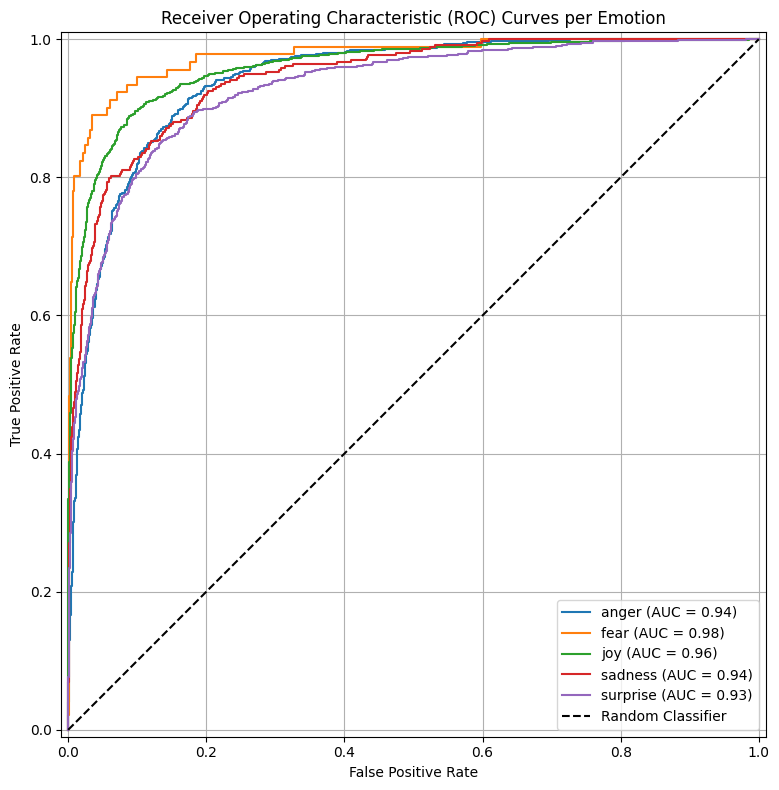

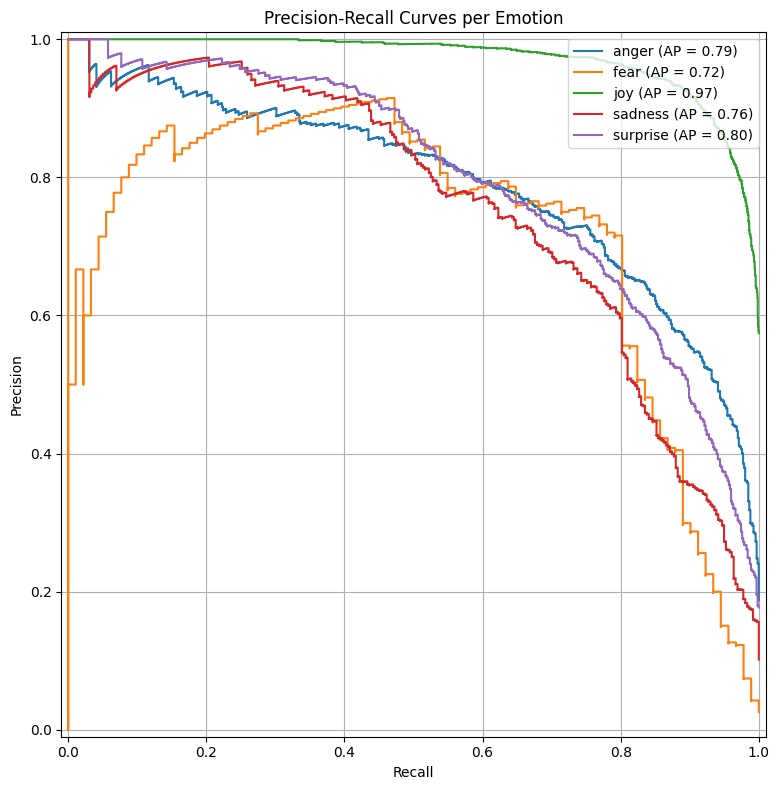

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, RocCurveDisplay, PrecisionRecallDisplay

# Convert raw outputs (logits) to probabilities using sigmoid
probabilities = torch.sigmoid(torch.tensor(raw_outputs)).cpu().numpy()

# --- ROC Curves per label ---
plt.figure(figsize=(10, 8))
for i, emotion in enumerate(target_cols):
    fpr, tpr, _ = roc_curve(true_targets[:, i], probabilities[:, i])
    roc_auc = auc(fpr, tpr)
    RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=emotion).plot(ax=plt.gca())

plt.title('Receiver Operating Characteristic (ROC) Curves per Emotion')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Precision-Recall Curves per label ---
plt.figure(figsize=(10, 8))
for i, emotion in enumerate(target_cols):
    display = PrecisionRecallDisplay.from_predictions(true_targets[:, i], probabilities[:, i], name=emotion, ax=plt.gca())

plt.title('Precision-Recall Curves per Emotion')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

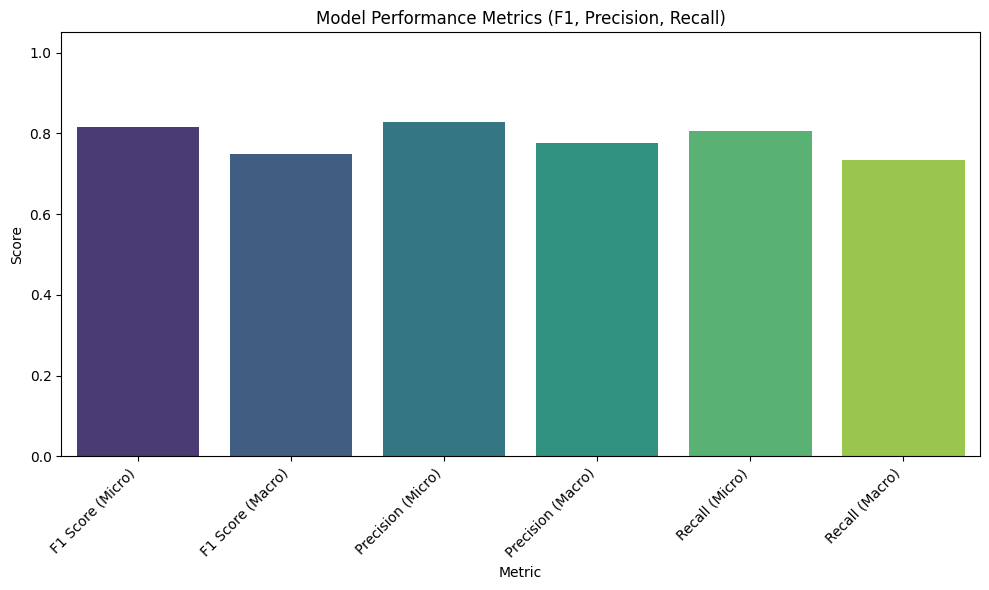

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
import numpy as np

# --- 1. Bar plot for F1, Precision, and Recall scores ---

# Calculate Precision and Recall scores
# Using zero_division=0 to handle cases where there are no true positives for a label
precision_score_micro = metrics.precision_score(true_targets, predictions, average='micro', zero_division=0)
precision_score_macro = metrics.precision_score(true_targets, predictions, average='macro', zero_division=0)
recall_score_micro = metrics.recall_score(true_targets, predictions, average='micro', zero_division=0)
recall_score_macro = metrics.recall_score(true_targets, predictions, average='macro', zero_division=0)

# F1 scores are already in kernel state (f1_score_micro, f1_score_macro)

metrics_data = {
    'Metric': ['F1 Score (Micro)', 'F1 Score (Macro)',
               'Precision (Micro)', 'Precision (Macro)',
               'Recall (Micro)', 'Recall (Macro)']
}

# Check if the variables are defined before using them in the 'Score' list
score_values = [
    f1_score_micro,
    f1_score_macro,
    precision_score_micro,
    precision_score_macro,
    recall_score_micro,
    recall_score_macro
]
metrics_data['Score'] = score_values

df_metrics = pd.DataFrame(metrics_data)

plt.figure(figsize=(10, 6))
sns.barplot(x='Metric', y='Score', data=df_metrics, palette='viridis')
plt.title('Model Performance Metrics (F1, Precision, Recall)')
plt.ylabel('Score')
plt.ylim(0, 1.05) # Extend y-axis slightly above 1 for better visualization
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

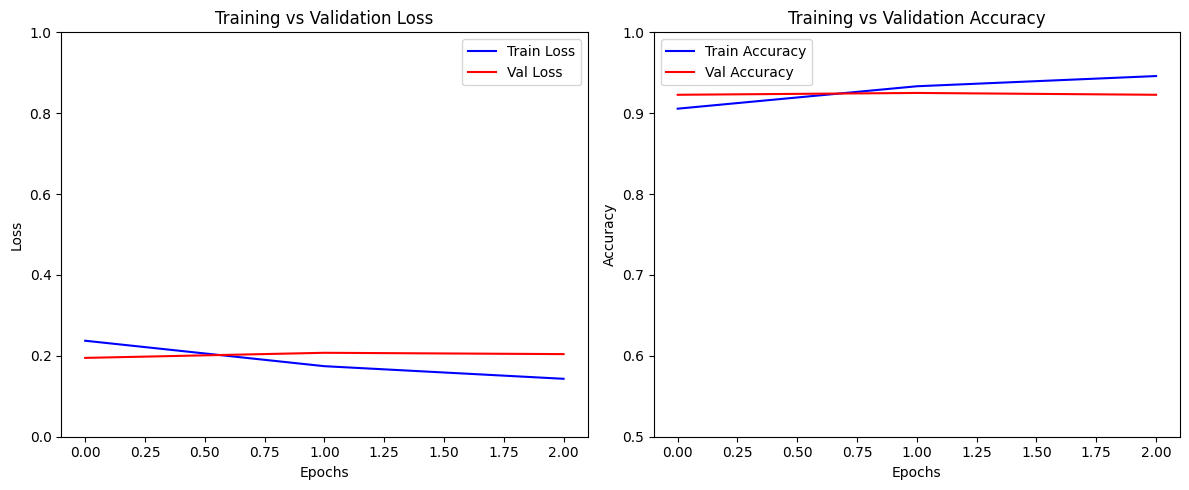

In [ ]:
import matplotlib.pyplot as plt

# --- Graph 1: Training vs Validation Loss ---
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss', color='blue')
plt.plot(history['val_loss'], label='Val Loss', color='red')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0, 1) # Set Y-axis limit for loss graph
plt.legend()

# --- Graph 2: Training vs Validation Accuracy ---
plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy', color='blue')
plt.plot(history['val_acc'], label='Val Accuracy', color='red')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0.5, 1) # Set Y-axis limit for accuracy graph
plt.legend()

plt.tight_layout()
plt.show()

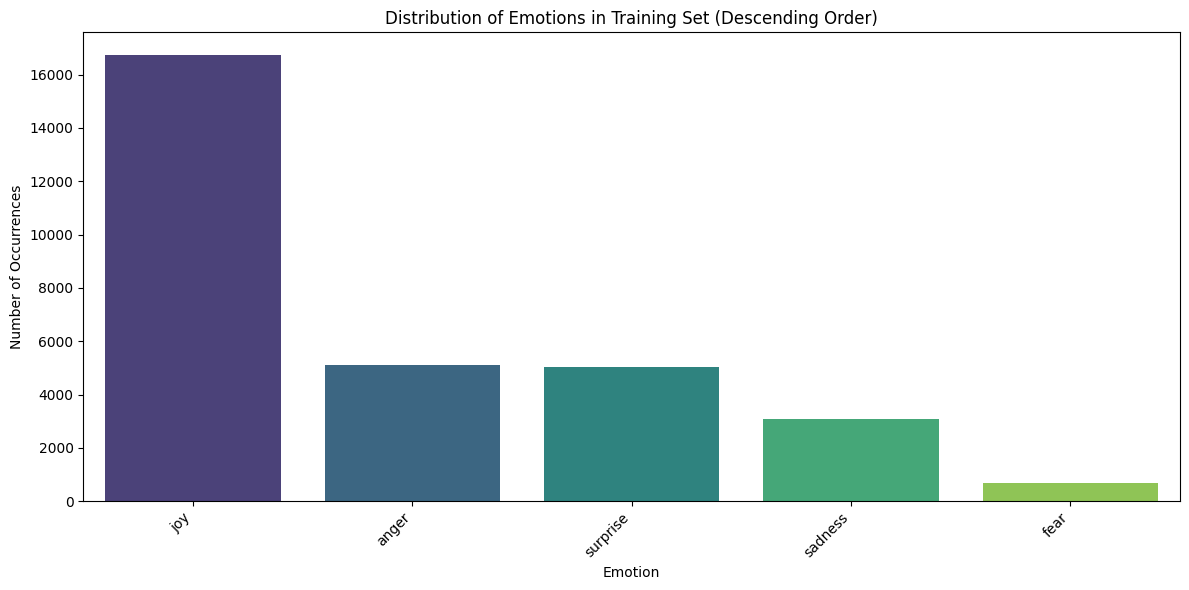

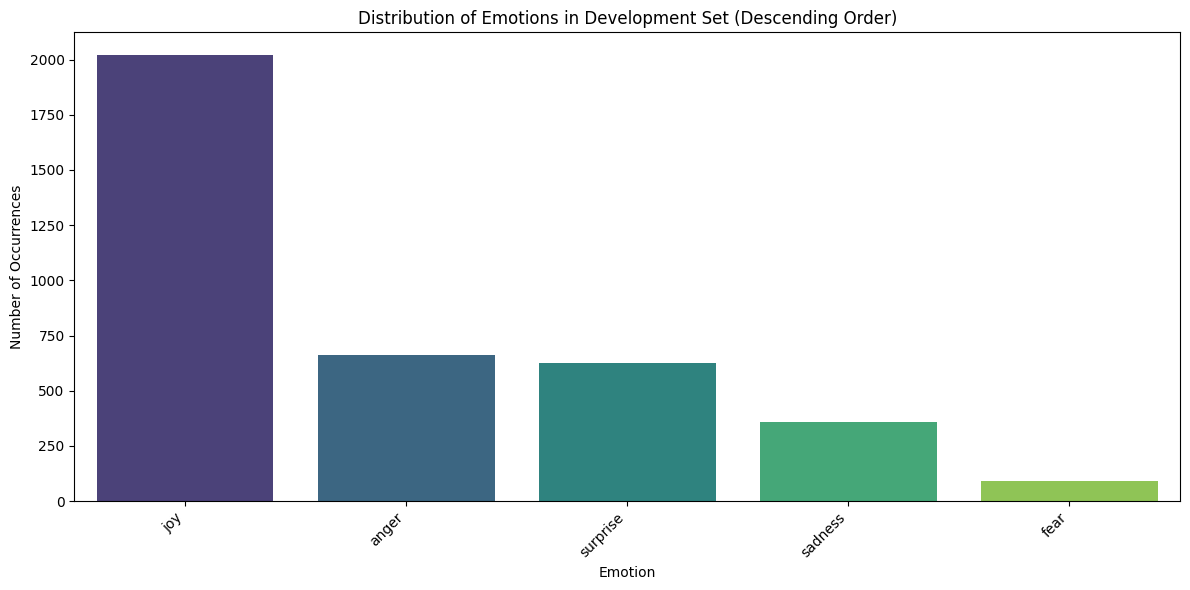

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get the emotion columns
emotion_columns = ['anger', 'fear', 'joy', 'sadness', 'surprise']

# Calculate the sum of each emotion column for training and development sets
train_emotion_counts = df_train[emotion_columns].sum()
dev_emotion_counts = df_dev[emotion_columns].sum()

# Create a DataFrame for plotting
df_train_emotions = train_emotion_counts.reset_index()
df_train_emotions.columns = ['Emotion', 'Count']
df_train_emotions['Dataset'] = 'Train'

df_dev_emotions = dev_emotion_counts.reset_index()
df_dev_emotions.columns = ['Emotion', 'Count']
df_dev_emotions['Dataset'] = 'Dev'

df_combined_emotions = pd.concat([df_train_emotions, df_dev_emotions])

# Calculate total counts for sorting (Descending order)
total_counts = df_combined_emotions.groupby('Emotion')['Count'].sum().sort_values(ascending=False)
# Create a categorical type for 'Emotion' based on the sorted total_counts
df_combined_emotions['Emotion'] = pd.Categorical(df_combined_emotions['Emotion'], categories=total_counts.index, ordered=True)

# --- Plotting the distribution of emotions for Training Set ---
plt.figure(figsize=(12, 6))
sns.barplot(x='Emotion', y='Count', data=df_combined_emotions[df_combined_emotions['Dataset'] == 'Train'], palette='viridis')
plt.title('Distribution of Emotions in Training Set (Descending Order)')
plt.xlabel('Emotion')
plt.ylabel('Number of Occurrences')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# --- Plotting the distribution of emotions for Development Set ---
plt.figure(figsize=(12, 6))
sns.barplot(x='Emotion', y='Count', data=df_combined_emotions[df_combined_emotions['Dataset'] == 'Dev'], palette='viridis')
plt.title('Distribution of Emotions in Development Set (Descending Order)')
plt.xlabel('Emotion')
plt.ylabel('Number of Occurrences')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

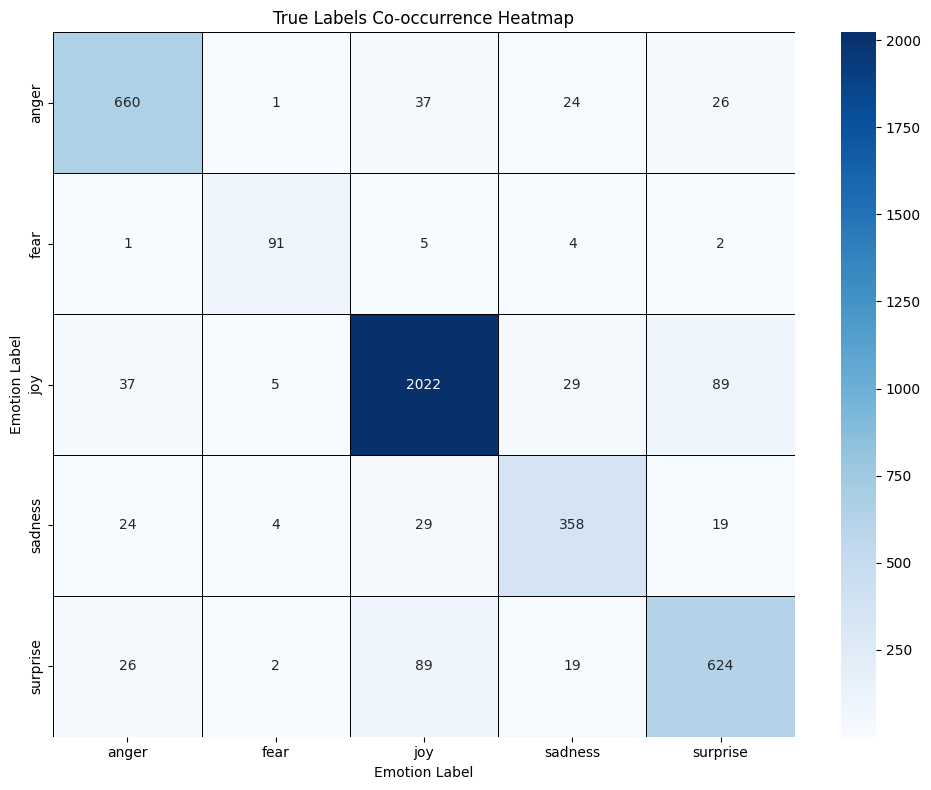

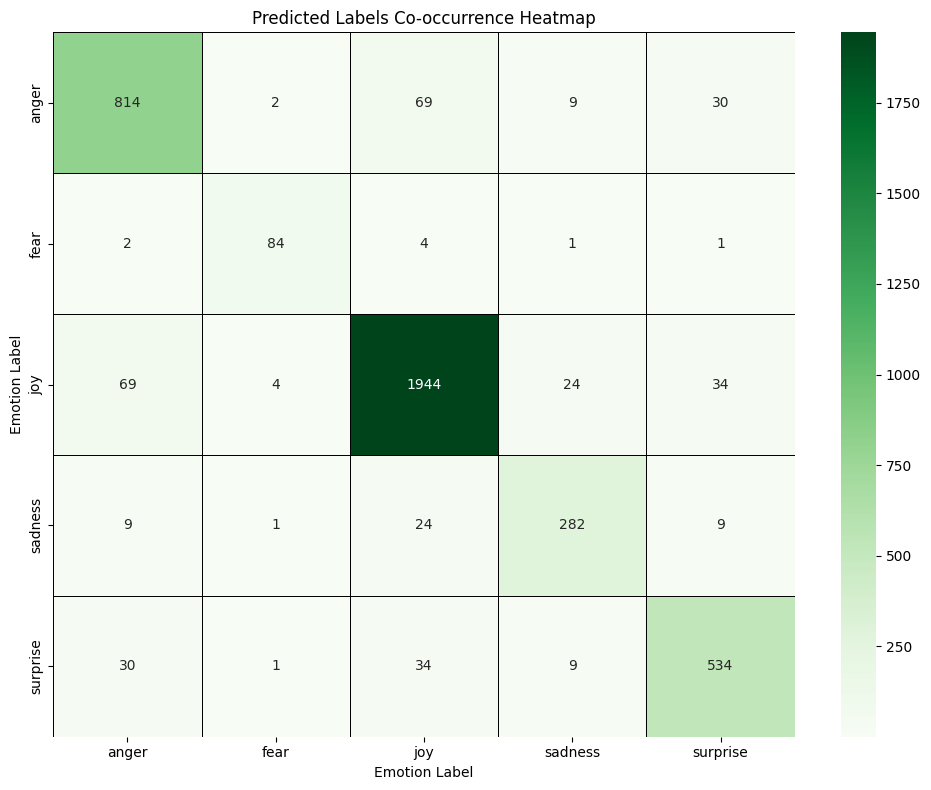

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def calculate_cooccurrence_matrix(labels, class_names):
    """Calculates the co-occurrence matrix for multi-label data."""
    num_classes = len(class_names)
    cooccurrence_matrix = np.zeros((num_classes, num_classes), dtype=int)

    for sample_labels in labels:
        # Find indices where label is present (value is 1)
        present_indices = np.where(sample_labels == 1)[0]
        for i in present_indices:
            for j in present_indices:
                cooccurrence_matrix[i, j] += 1

    return pd.DataFrame(cooccurrence_matrix, index=class_names, columns=class_names)

# --- 1. True Labels Co-occurrence Heatmap ---

true_cooccurrence_df = calculate_cooccurrence_matrix(true_targets, target_cols)

plt.figure(figsize=(10, 8))
sns.heatmap(true_cooccurrence_df, annot=True, fmt='d', cmap='Blues', linewidths=.5, linecolor='black')
plt.title('True Labels Co-occurrence Heatmap')
plt.xlabel('Emotion Label')
plt.ylabel('Emotion Label')
plt.tight_layout()
plt.show()

# --- 2. Predicted Labels Co-occurrence Heatmap ---

predicted_cooccurrence_df = calculate_cooccurrence_matrix(predictions, target_cols)

plt.figure(figsize=(10, 8))
sns.heatmap(predicted_cooccurrence_df, annot=True, fmt='d', cmap='Greens', linewidths=.5, linecolor='black')
plt.title('Predicted Labels Co-occurrence Heatmap')
plt.xlabel('Emotion Label')
plt.ylabel('Emotion Label')
plt.tight_layout()
plt.show()

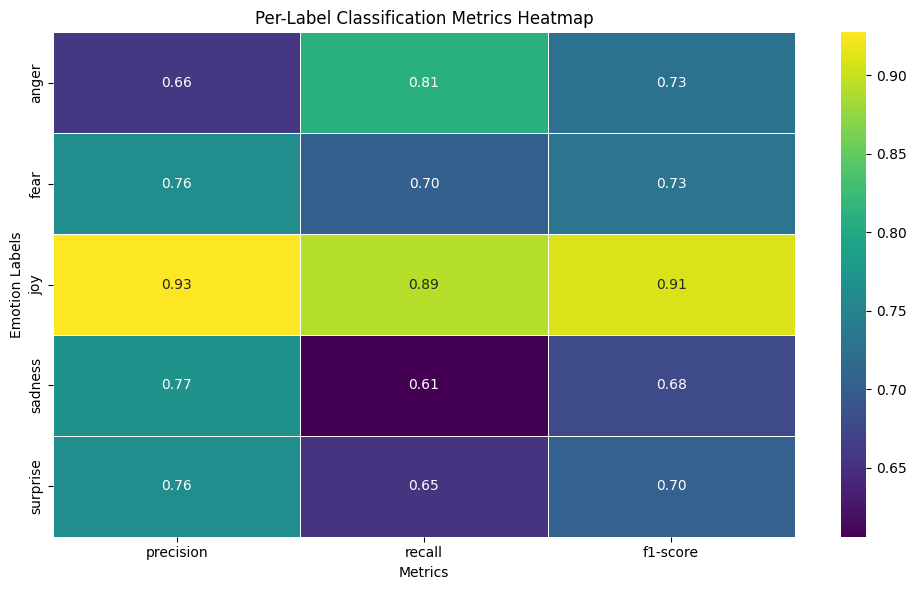

In [ ]:
from sklearn.metrics import classification_report
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Generate a classification report
report = classification_report(true_targets, predictions, target_names=target_cols, output_dict=True)

# Convert the report to a DataFrame for easier plotting
df_report = pd.DataFrame(report).transpose()

# Filter out 'accuracy', 'macro avg', 'weighted avg' rows if present, focusing on per-label metrics
df_report = df_report.loc[target_cols]

# Select metrics for heatmap (precision, recall, f1-score)
metrics_to_plot = df_report[['precision', 'recall', 'f1-score']]

# Create the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(metrics_to_plot, annot=True, cmap='viridis', fmt=".2f", linewidths=.5)
plt.title('Per-Label Classification Metrics Heatmap')
plt.xlabel('Metrics')
plt.ylabel('Emotion Labels')
plt.tight_layout()
plt.show()

In [ ]:
print("--- Final Model Performance ---")
print(f"Final Training Loss: {history['train_loss'][-1]:.4f}")
print(f"Final Validation Loss: {history['val_loss'][-1]:.4f}")
print(f"Final Training Accuracy: {history['train_acc'][-1]:.4f}")
print(f"Final Validation Accuracy: {history['val_acc'][-1]:.4f}")
print("\n--- Overall Metrics on Validation Set ---")
print(f"Accuracy Score: {accuracy:.4f}")
print(f"F1 Score (Micro): {f1_score_micro:.4f}")
print(f"F1 Score (Macro): {f1_score_macro:.4f}")
print(f"Precision (Micro): {precision_score_micro:.4f}")
print(f"Precision (Macro): {precision_score_macro:.4f}")
print(f"Recall (Micro): {recall_score_micro:.4f}")
print(f"Recall (Macro): {recall_score_macro:.4f}")

--- Final Model Performance ---
Final Training Loss: 0.1432
Final Validation Loss: 0.2043
Final Training Accuracy: 0.9459
Final Validation Accuracy: 0.9228

--- Overall Metrics on Validation Set ---
Accuracy Score: 0.7568
F1 Score (Micro): 0.8167
F1 Score (Macro): 0.7499
Precision (Micro): 0.8275
Precision (Macro): 0.7760
Recall (Micro): 0.8061
Recall (Macro): 0.7331


In [ ]:
import torch

# Define a path to save your model
model_save_path = "emotion_deberta_model.pth"

# Save only the model's state_dict
torch.save(model.state_dict(), model_save_path)

print(f"Model saved successfully to {model_save_path}")

Model saved successfully to emotion_deberta_model.pth


You can then load the model's state dictionary back into a new instance of your model class like this:

In [ ]:
import torch

# Instantiate your model class (it must be defined exactly as it was during training)
# If you run this in a new environment, make sure DeBERTaClass is defined
# and that AutoModel is imported and 'microsoft/deberta-v3-base' is accessible.
loaded_model = DeBERTaClass()

# Load the state dictionary
loaded_model.load_state_dict(torch.load(model_save_path))

# Move the loaded model to the appropriate device
loaded_model.to(device)

# Set the model to evaluation mode (important for inference)
loaded_model.eval()

print("Model loaded successfully!")

Model loaded successfully!
